#Install Dependencies

In [2]:
!pip install tensorflow opencv-python-headless matplotlib

In [3]:
import sys
print(sys.executable)

/Users/gabrielschull/anaconda3/envs/facialrecognition/bin/python


In [4]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [5]:
#import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [6]:
#Set GPU Memory Consumption Growth to avoid OOM errors -> wrong tensorflow version for this, not necessary though
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
#Make dirs
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [10]:
#Collecting labelled faces in the wild dataset at http://vis-www.cs.umass.edu/lfw/ (as gzipped tar file)

In [11]:
#uncompress Tar Labelled Faces in the Wild dataser
#!tar -xf lfw.tar

In [12]:
# Move lfw imgs to the following repo data/negative
#for directory in os.listdir('lfw'):
   # for file in os.listdir(os.path.join('lfw', directory)):
       # EX_PATH = os.path.join('lfw', directory, file)
       # NEW_PATH = os.path.join(NEG_PATH, file)
       # os.replace(EX_PATH, NEW_PATH)
    

In [13]:
import uuid

In [14]:
#Collect positive and anchor classes

cap = cv2.VideoCapture(0) #Establish a connection to the webcam
while cap.isOpened():
    ret, frame = cap.read() 
    
    #cut down to 250x250px frame
    frame = frame[250:250+250,475:475+250,:]

    key = cv2.waitKey(1) & 0XFF

    #collect anchors
    if key == ord('a'):
        #create unique filepath
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
        break

    #collect positives
    if key == ord('p'):
        #create unique filepath
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
        break
        
        
    #show image back to screen
    cv2.imshow('Image Collection', frame)

    #breaking if q hit on keyboard after 1 ms
    if key == ord('q'):
        break
#release webcam & close the image show frame
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

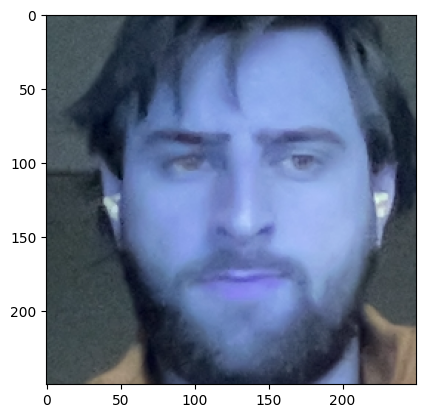

In [15]:
plt.imshow(frame)

In [16]:
#Load and preprocess Images
# get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2024-02-27 12:09:49.595262: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-27 12:09:49.595294: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-27 12:09:49.595298: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-27 12:09:49.596002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-27 12:09:49.597035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data/anchor/95d60178-d2a2-11ee-aa4a-563466da705a.jpg'


In [19]:
#Preprocessing - scale and resize

def preprocess(file_path):

    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    # preprocessing steps - resize image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # scale image to be between 0 and 1
    img = img / 255.0

    
    return img

In [20]:
img = preprocess('data/anchor/8de3e8e0-d2a2-11ee-aa4a-563466da705a.jpg')

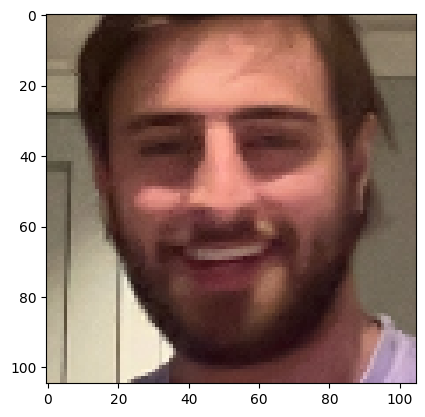

In [21]:
plt.imshow(img)

In [22]:
#dataset.map(preprocess)

In [23]:
# Create labelled dataset
# (anchor, positive) =>  1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [24]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

In [26]:
example = samples.next()

In [27]:
example

(b'data/anchor/78f05a44-d29e-11ee-bb71-563466da705a.jpg',
 b'data/positive/071894ae-d2a3-11ee-ab5a-563466da705a.jpg',
 1.0)

In [28]:
# Build Train and Test Partition
def preprocess_twin(input_img, validation_img, label):
     return (preprocess(input_img), preprocess(validation_img), label)

In [29]:
preprocess_twin(*example)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.5187742 , 0.45210755, 0.37367615],
         [0.53009874, 0.4637122 , 0.38444045],
         [0.5444    , 0.4816549 , 0.39145884],
         ...,
         [0.24753694, 0.17694871, 0.13640359],
         [0.30897033, 0.23474061, 0.18022546],
         [0.3485595 , 0.27526352, 0.20495538]],
 
        [[0.5252768 , 0.45861015, 0.38017878],
         [0.5153662 , 0.44897962, 0.36970788],
         [0.5276777 , 0.46493268, 0.37473658],
         ...,
         [0.20578237, 0.13127257, 0.10382158],
         [0.27054834, 0.19267718, 0.14982003],
         [0.2928305 , 0.21832068, 0.15724292]],
 
        [[0.54225916, 0.4755925 , 0.3971611 ],
         [0.5500467 , 0.48530748, 0.40109378],
         [0.5392335 , 0.47648838, 0.3862923 ],
         ...,
         [0.19942202, 0.12491221, 0.09843272],
         [0.23071903, 0.15284786, 0.11727364],
         [0.34540042, 0.27089062, 0.21477483]],
 
        ...,
 
        [[0.61960787, 0.5764706 

In [30]:
# Build dataLoader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [31]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [33]:
train_samples = train_data.as_numpy_iterator()

In [34]:
train_sample = train_samples.next()

In [35]:
len(train_sample[0])

16

In [36]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [37]:
inp = Input(shape=(105,105,3), name='input_image')

In [38]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [39]:
m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

In [40]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

In [41]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

In [42]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [43]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [45]:
# Build embedding layer
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')


In [53]:
embedding = make_embedding()

In [54]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 21, 21, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       26

In [49]:
# Build distance Layer
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Compare similarity
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [50]:
l1 = L1Dist()

In [52]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [69]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [72]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [74]:
siamese_layer = L1Dist()

In [78]:
distances = siamese_layer(inp_embedding, val_embedding)

In [79]:
classifier = Dense(1, activation='sigmoid')(distances)

In [80]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [81]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [83]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 105, 105, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 105, 105, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [ ]:
def make_siamese_model():

    # Anchor image inputs in network
    input_image = Input(name='input_img', shape=(105,105,3))
    # Validation image in network
    validation_image = Input(name='validation_img', shape=(105,105,5))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classificaiton layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')